In [1]:
#imports for data manipulation
import pandas as pd
import numpy as np

#imports for visualisation
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

#imports for testing cointegration
from statsmodels.tsa.stattools import coint, adfuller
from itertools import combinations

#ML imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

#other imports
import glob
import os

# Set default parameters for plots
plt.rcParams.update({
    'figure.figsize': (16, 8),      # Default figure size (width, height)
    'axes.grid': True,              # Enable grid by default
    'grid.alpha': 0.5,              # Grid line transparency
    'grid.linestyle': '--',         # Grid line style
    'grid.color': 'gray',           # Grid line color
    'axes.titlesize': 14,           # Default title font size
    'axes.labelsize': 12,           # Default x and y label font size
    'xtick.labelsize': 10,          # X-axis tick label font size
    'ytick.labelsize': 10,          # Y-axis tick label font size
    'legend.fontsize': 11,          # Default legend font size
    'legend.frameon': True,         # Enable legend frame
    'legend.loc': 'best'            # Default legend location
})


In [2]:
data_folder = "Potentially Correlated"
csvfiles = glob.glob(os.path.join(data_folder, "*.csv"))
dataframes = []
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    dataframes.append((os.path.basename(csvfile), df))  # Store as tuple (filename, DataFrame)

filtered_frames = []
for filename, df in dataframes:
    filtered_df = df.loc["2024-09-26":"2024-09-27"]
    filtered_frames.append((filename, filtered_df))

sept26=[]
sept27=[]
for frame in filtered_frames:
    sept26.append([frame[0],frame[1].loc["2024-09-26"]])
    sept27.append([frame[0],frame[1].loc["2024-09-27"]])

sept27 #A list of dataframes from the 27th
sept26 #A list of dataframes from the 26th


[['ACC_minute.csv',
                          open     high      low    close  volume
  date                                                           
  2024-09-26 09:15:00  2460.00  2468.00  2444.45  2447.55    1435
  2024-09-26 09:16:00  2451.45  2452.85  2448.05  2452.70     494
  2024-09-26 09:17:00  2452.70  2452.95  2447.55  2449.00     906
  2024-09-26 09:18:00  2448.65  2455.30  2448.65  2455.30    1454
  2024-09-26 09:19:00  2455.30  2455.45  2451.60  2451.60     569
  ...                      ...      ...      ...      ...     ...
  2024-09-26 15:25:00  2475.05  2475.50  2474.25  2475.05    1117
  2024-09-26 15:26:00  2475.10  2477.95  2474.90  2475.00    1301
  2024-09-26 15:27:00  2477.35  2477.60  2473.55  2475.75    1134
  2024-09-26 15:28:00  2475.75  2476.00  2475.75  2475.95     923
  2024-09-26 15:29:00  2475.00  2476.35  2470.00  2474.90    1588
  
  [375 rows x 5 columns]],
 ['ADANIENSOL_minute.csv',
                          open     high      low    close  volume

We'll work with data from 26th to develop the strategy, and we'll test it afterwards with data from 27th. First let's normalise them all and plot them, to visualise what's going on.

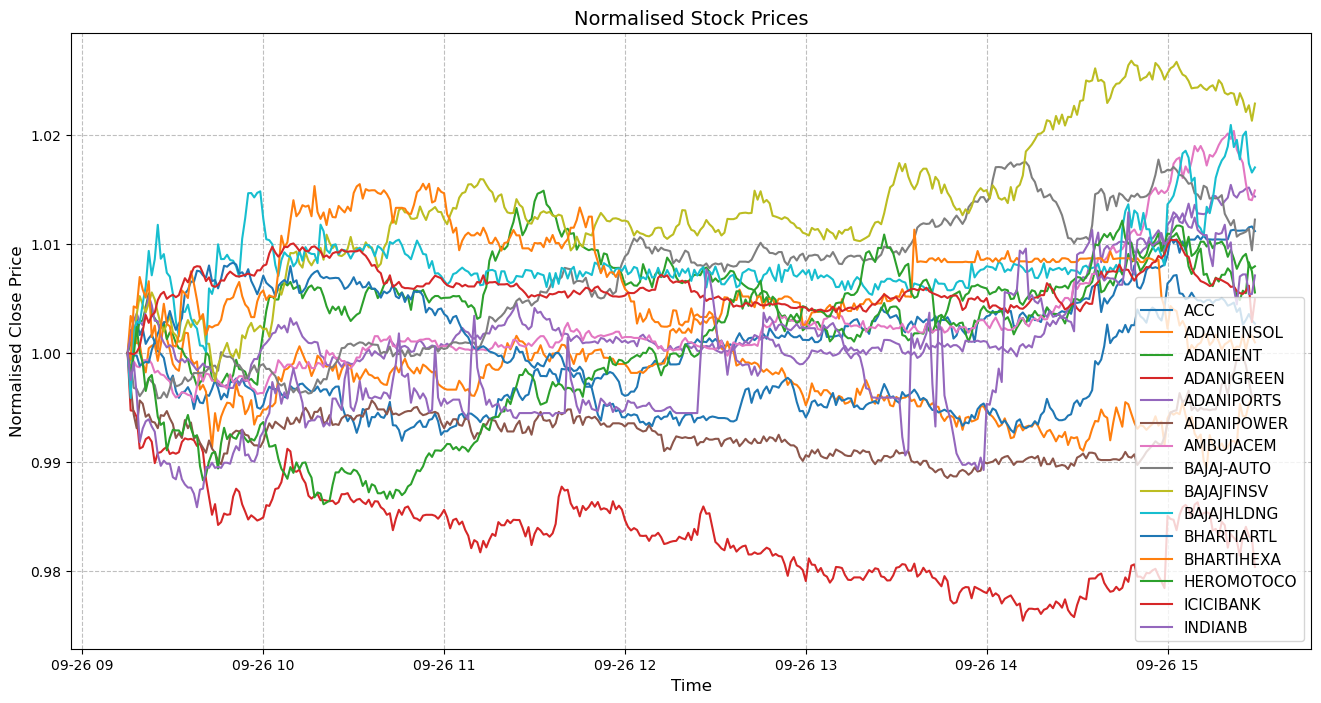

In [3]:
for i, df in enumerate(sept26):
    plt.plot(df[1].index, df[1]["close"]/df[1]["close"][0], label=f"{df[0]}"[:-11])
    
plt.xlabel("Time")
plt.ylabel("Normalised Close Price")
plt.title("Normalised Stock Prices")
plt.legend()
plt.show()


Doesn't show us much for now, but later on we'll find a cointegrated pair, normalise them and plot them to see how they move together. Let's find all the cointegrated pairs. We'll take every possible pair, compute their correlation, and perform a cointegration test. The cointegration test tests the null hypothesis that the pair are on cointegrated; a p-value of <0.01 indicates that it is highly unlikely that the null hypothesis is true, leading us to reject the null hypothesis and conclude that it is likely that the pair are cointegrated.

In addition, we will only include those stocks whose correlation is positive. This is just a choice we make, we could also implement a strategy with pairs that are negatively correlated.

In [4]:
coint_corr_series=[]

for combo in combinations(sept26, 2):
    corr=combo[0][1]["close"].corr(combo[1][1]["close"])
    score, p_value, _ = coint(combo[0][1]["close"], combo[1][1]["close"])
    
    if p_value < 0.01 and corr>0: #if the series are cointegrated and positively correlated, append
        coint_corr_series.append([combo, corr, score, p_value])


In [5]:
if coint_corr_series:
    highest_coint_pair = min(coint_corr_series, key=lambda x: x[3])
    result = [highest_coint_pair]
else:
    result = []

result

[[(['BAJAJFINSV_minute.csv',
                            open     high      low    close  volume
    date                                                           
    2024-09-26 09:15:00  1940.00  1940.00  1933.45  1935.15   24303
    2024-09-26 09:16:00  1935.50  1937.00  1932.15  1933.35   12523
    2024-09-26 09:17:00  1933.90  1937.95  1932.80  1936.60    9299
    2024-09-26 09:18:00  1936.80  1942.00  1936.20  1942.00   17524
    2024-09-26 09:19:00  1942.00  1947.45  1942.00  1945.25   24040
    ...                      ...      ...      ...      ...     ...
    2024-09-26 15:25:00  1981.40  1981.40  1979.55  1980.00    9449
    2024-09-26 15:26:00  1980.00  1981.25  1977.90  1977.90   14277
    2024-09-26 15:27:00  1978.75  1981.00  1976.60  1979.10    7062
    2024-09-26 15:28:00  1979.10  1981.00  1975.90  1976.35    6112
    2024-09-26 15:29:00  1976.35  1980.00  1975.05  1979.40    8224
    
    [375 rows x 5 columns]],
   ['INDIANB_minute.csv',
                           

The pair with the lowest p-value for cointegration is (Indian Bank, Bajaj Finserv). The p-value is well below our significance level \alpha=0.01, so it is highly likely that these two stocks are cointegrated. This is plausible; they are both in the financial services sector. Let's extract the dataframes and plot them.

In [6]:
bajaj26=result[0][0][0][1]
indianb26=result[0][0][1][1]

Normalise the time series and plot them so we can visualise their movement together more easily.

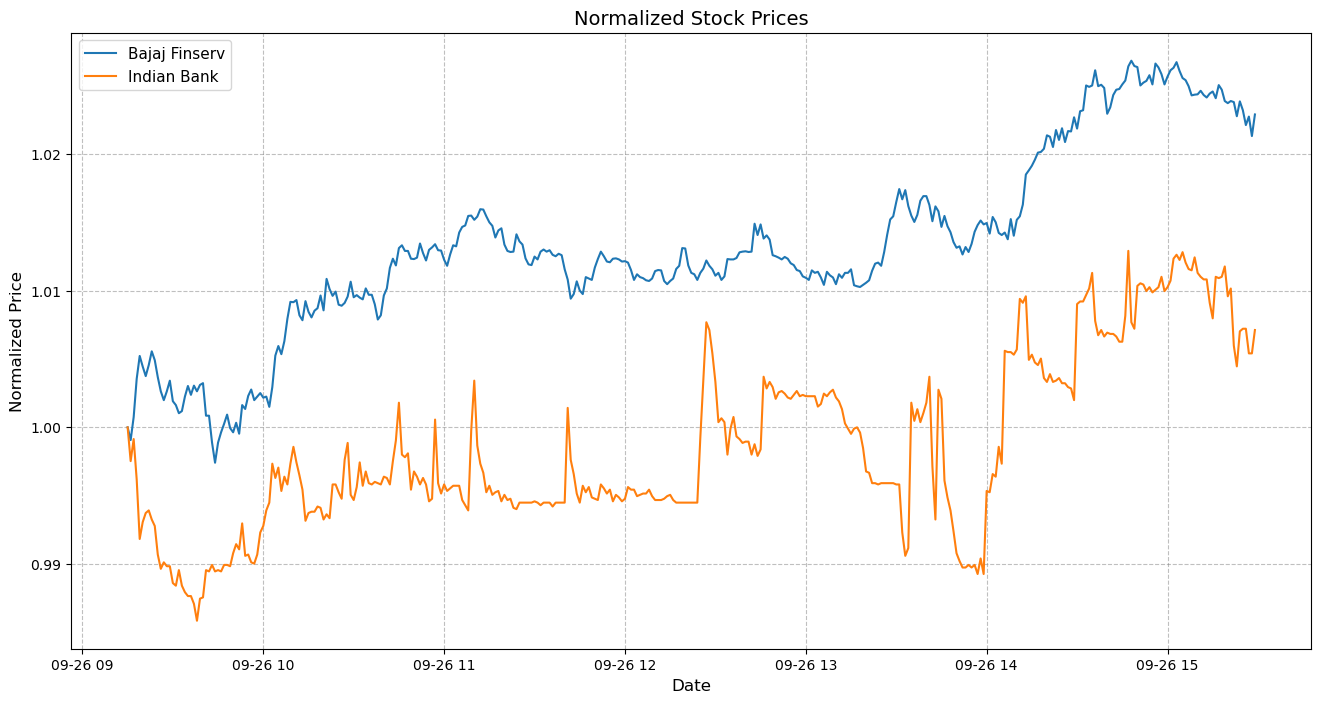

In [7]:
bajaj26_norm = bajaj26["close"] / bajaj26["close"].iloc[0]
indianb26_norm = indianb26["close"] / indianb26["close"].iloc[0]

# Plot the normalised series
plt.plot(bajaj26_norm, label='Bajaj Finserv')
plt.plot(indianb26_norm, label='Indian Bank')
plt.title("Normalized Stock Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

bajaj26_norm=pd.DataFrame(bajaj26_norm)
indianb26_norm=pd.DataFrame(indianb26_norm)


We see that the two roughly move together, but there are periods where the spread between them grows and periods where it shrinks. This is exactly what we need for a pairs trading strategy.

Consider two stocks, stock1 and stock2. The definition of cointegration is that if there exists some linear combination of stock1 and stock2 that results in a stationary time series, stock1 and stock2 are said to be cointegrated. In other words, if stock1 and stock2 are cointegrated, then we should be able to remove their dependence on eachother and leave behind stationary noise.

What is that linear combination? We are interested in a linear combination of stock1 and stock2 of the form

\alpha + \error = stock1 - \beta * stock2,

for \alpha some constant, \error some noise, and \beta some coefficient. Namely we want to find \alpha and \beta such that

stock1 = \alpha + (\beta * stock2) + \error.

This is just a linear regression problem. In the context of pairs trading we call \beta the "hedge ratio"; it tells us how much of stock2 to short for every unit of stock1 we go long. We will compute hedge ratios for shorting stock2 as well as for shorting stock1.

In [8]:
def hedge_ratios(stock1, stock2):
    stock1_lr = stock1["close"].values.reshape(-1, 1)
    stock2_lr = stock2["close"].values.reshape(-1, 1)

    linear_model2=LinearRegression()
    linear_model2.fit(stock2_lr, stock1_lr)

    beta2=linear_model2.coef_[0][0] #When we're going long stock1, we short beta2 units of stock2
    alpha2=linear_model2.intercept_[0]


    linear_model1=LinearRegression()
    linear_model1.fit(stock1_lr, stock2_lr)

    beta1=linear_model1.coef_[0][0] #When we're going long stock2, we short beta1 units of stock1
    alpha1=linear_model1.intercept_[0]
    
    return [(alpha1, beta1), (alpha2, beta2)]

In [9]:
beta1=hedge_ratios(bajaj26, indianb26)[0][1]
beta2=hedge_ratios(bajaj26, indianb26)[1][1]
print(beta1, beta2)

stationary26=pd.DataFrame()
stationary26["spread"]=bajaj26["close"]-beta2*indianb26["close"]
stationary26["mean spread"]=stationary26["spread"].mean()
stationary26

0.20722704720306384 3.1413244072211146


,spread,mean spread
date,,
2024-09-26 09:15:00,279.043773,306.954219
2024-09-26 09:16:00,281.327494,306.954219
2024-09-26 09:17:00,281.907368,306.954219
2024-09-26 09:18:00,292.176421,306.954219
2024-09-26 09:19:00,302.651467,306.954219
...,...,...
2024-09-26 15:25:00,311.956740,306.954219
2024-09-26 15:26:00,309.856740,306.954219
2024-09-26 15:27:00,314.040998,306.954219


Now plot the resulting series, and perform the augmented Dickey-Fuller test for stationarity. The D-F test is a test of the null hypothesis that the series is not stationary. A low p-value indicates a low probability that the series is not stationary, which would lead us to reject the null hypothesis and conclude that the series is likely to be stationary.

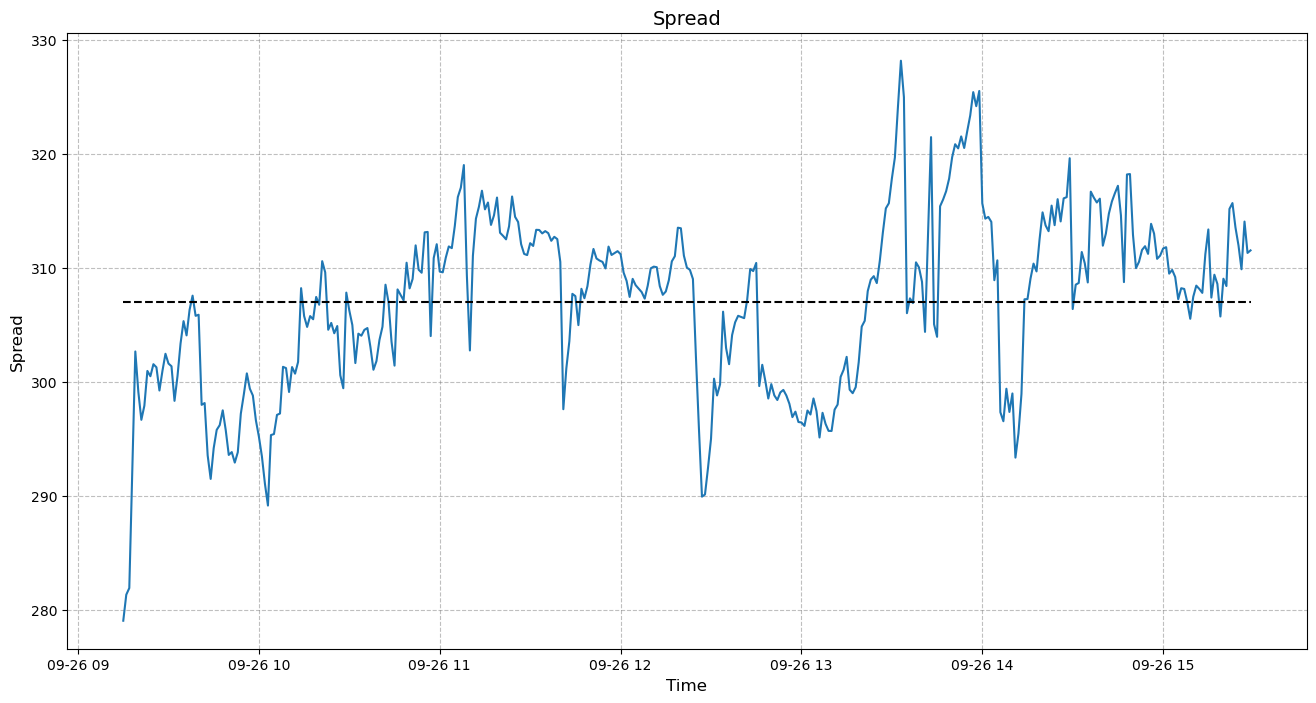

p=0.00015571258153072333 < 0.01; Spread is likely to be stationary


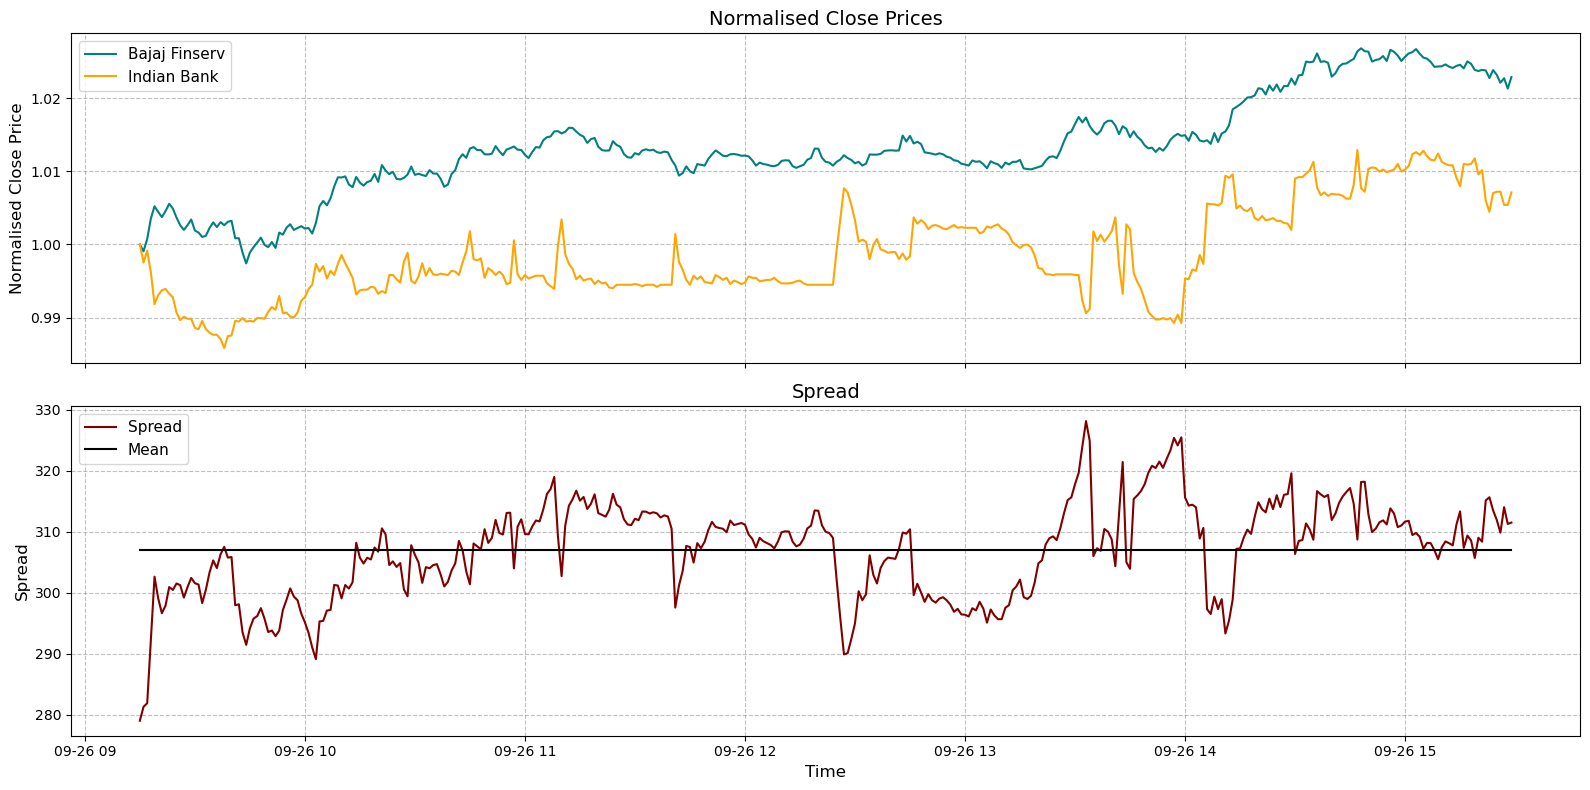

In [10]:
plt.plot(stationary26.index, stationary26["spread"])
plt.plot(stationary26.index, stationary26["mean spread"], c="black", linestyle="--")
plt.title("Spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()

p_value=adfuller(stationary26["spread"])[1]
if p_value<0.01:
    print(f"p={p_value} < 0.01; Spread is likely to be stationary")
else:
    print(f"p={p_value} > 0.01; We cannot reject the null hypothesis that the series is not stationary")
    
    
    

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))

#Normalised stock price plot
ax1.plot(stationary26.index, bajaj26_norm, label='Bajaj Finserv', color='teal')
ax1.plot(stationary26.index, indianb26_norm, label='Indian Bank', color='orange')
ax1.set_title("Normalised Close Prices")
ax1.set_ylabel("Normalised Close Price")
ax1.legend()

#Corresponding spread plot
ax2.plot(stationary26.index, stationary26["spread"], label='Spread', color='maroon')
ax2.plot(stationary26.index, stationary26["mean spread"], label='Mean', color='black')
ax2.set_title("Spread")
ax2.set_xlabel("Time")
ax2.set_ylabel("Spread")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

Our p-value is well below our significance level of 0.01, so we find that using the hedge ratio we found from the linear regression we can create a stationary time series of the spread.

Now, let's simulate trading using the hedge ratios we found earlier. If the spread goes above the mean by n standard deviations, we will short beta1 units of stock1 and long 1 unit of stock2. If the spread goes below the mean by n standard deviations, we will short beta2 units of stock2 and long 1 unit of stock1.


In [11]:
def strategy(stationary, stock1, stock2, initial_allocation, beta1, beta2, n=1):
    mean = stationary["spread"].mean()
    std = stationary["spread"].std()
    upper_threshold = mean + n * std
    lower_threshold = mean - n * std
    
    position = 0  # 0 if no position, 1 if long stock1/short stock2, -1 if short stock1/long stock2
    cash = initial_allocation #how much cash we've got through the trade
    stock1_units = 0
    stock2_units = 0

    portfolio_values=[]
    trade_log=[]

    for index, row in stationary.iterrows():
        current_spread = row["spread"]
        current_stock1_price = stock1["close"][stationary.index.get_loc(index)]
        current_stock2_price = stock2["close"][stationary.index.get_loc(index)]

        if position == 1:  # Long stock1, short stock2
            portfolio_value = cash + (stock1_units * current_stock1_price) - (stock2_units * current_stock2_price)
        elif position == -1:  # Long stock2, short stock1
            portfolio_value = cash + (stock2_units * current_stock2_price) - (stock1_units * current_stock1_price)
        else:  # No position
            portfolio_value = cash

        portfolio_values.append((index, portfolio_value))
    
        # Entering and exiting positions based on thresholds defined above
        if position == 0: #if we're not currently in a position, enter one if the spread is sufficiently away from the mean
            if current_spread <= lower_threshold: #if the spread is smaller 
                # long 1 unit of stock1, short beta2 units of stock2
                position = 1
                stock1_units=1
                stock2_units=beta2
            
                trade_log.append([index, cash, "Entering position"]) 
                cash -= stock1_units * current_stock1_price #buy 1 unit of stock1
                trade_log.append([index, cash, f"Just Bought {stock1_units} unit stock1"])
                cash += stock2_units * current_stock2_price #sell beta2 units of stock2
                trade_log.append([index, cash, f"Just Sold {stock2_units} units stock2"])
            

            elif current_spread >= upper_threshold:
                # long 1 unit of stock2, short beta1 units of stock1
                position = -1
                stock2_units = 1
                stock1_units = beta1
            
                trade_log.append([index, cash, "Entering Position"])
                cash -= stock2_units * current_stock2_price  #buy 1 unit of stock2
                trade_log.append([index, cash, f"Just Bought {stock2_units} unit stock2"])
                cash += stock1_units * current_stock1_price #sell beta1 units of stock1
                trade_log.append([index, cash, f"Just Sold {stock1_units} stock1"])


        elif position == 1: #if we're currently in a long position on stock 1, short position on stock 2
            if current_spread > mean:
                # Close long position in stock1 and the short position in stock2 
                trade_log.append([index, cash, "Closing Position"])
                cash += stock1_units * current_stock1_price #ie we sell stock1
                trade_log.append([index, cash, f"Just Sold {stock1_units} stock1"])
                cash -= stock2_units * current_stock2_price #and we have to buy back the stock we shorted
                trade_log.append([index, cash, f"Just Bought {stock2_units} stock2"])
            
                position = 0 #closed position
                stock1_units = 0
                stock2_units = 0


        elif position == -1: #if we're currently in a short position on stock 1, long position on stock 2
            if current_spread < mean:
                # Close short position
                trade_log.append([index, cash, "Closing Position"])
                cash += stock2_units * current_stock2_price #ie we sell stock2
                trade_log.append([index, cash, f"Just Sold {stock2_units} stock2"])
                cash -= stock1_units * current_stock1_price #and we have to buy back the stock we shorted
                trade_log.append([index, cash, f"Just Bought {stock1_units} stock1"])
            
                position = 0 #closed position
                stock1_units = 0
                stock2_units = 0

        if index==stationary.index[-1] and position!=0:
            if position==1:
                # Close long position in stock1 and the short position in stock2 
                trade_log.append([index, cash, "Closing Position"])
                cash += stock1_units * current_stock1_price #ie we sell stock1
                trade_log.append([index, cash, f"Just Sold {stock1_units} stock1"])
                cash -= stock2_units * current_stock2_price #and we have to buy back the stock we shorted
                trade_log.append([index, cash, f"Just Bought {stock2_units} stock2"])
            
                position = 0 #closed position
                stock1_units = 0
                stock2_units = 0
            else:
                # Close short position in stock1 and long position in stock2
                trade_log.append([index, cash, "Closing Position"])
                cash += stock2_units * current_stock2_price #ie we sell stock2
                trade_log.append([index, cash, f"Just Sold {stock2_units} stock2"])
                cash -= stock1_units * current_stock1_price #and we have to buy back the stock we shorted
                trade_log.append([index, cash, f"Just Bought {stock1_units} stock1"])
            
                position = 0 #closed position
                stock1_units = 0
                stock2_units = 0
                
    final_cash=cash
    pnl = final_cash - initial_allocation 
    
    return pnl, final_cash, trade_log, portfolio_values


Let's plot the performance of the strategy over the day.

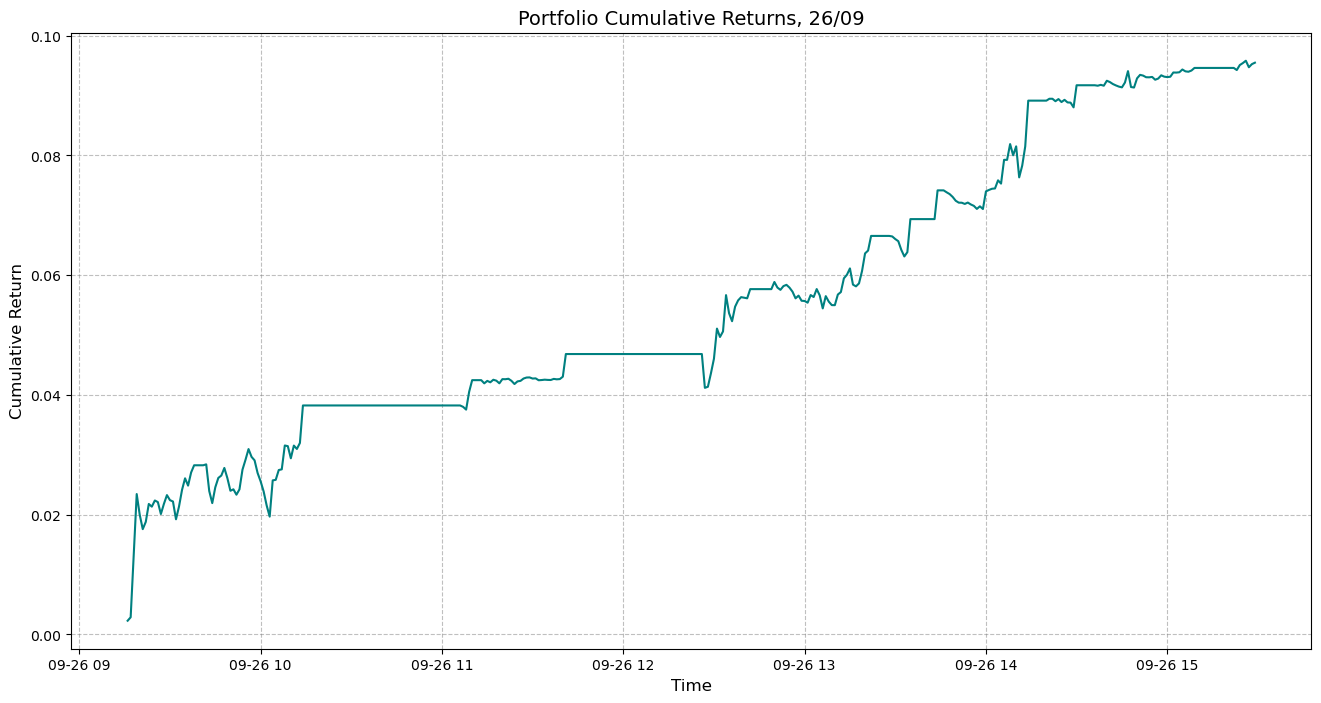

In [12]:
portfolio_26_df = pd.DataFrame(strategy(stationary26, bajaj26, indianb26, 1000, beta1, beta2, 1)[3], columns=['Date', 'Portfolio Value'])
portfolio_26_df.set_index('Date', inplace=True)


portfolio_26_df["Minutely Return"] = portfolio_26_df["Portfolio Value"].pct_change()

# Plotting the portfolio returns over time
plt.plot(portfolio_26_df["Minutely Return"].cumsum(), c="teal")
plt.title("Portfolio Cumulative Returns, 26/09")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

So the strategy makes money. This is somewhat expected; we know that the spread is stationary on this particular day using the particular hedge ratio we computed, we know that the two stocks are cointegrated, and we know that they remain cointegrated for the whole day. Therefore, it isn't wildly surprising that the strategy makes money.

To really test whether this is a viable strategy we should test it on unseen data using these same hedge ratios; for instance on data from the next day. We don't have any information about the next day; will the two remain cointegrated? This seems likely, but it isn't guaranteed.

First let's compute the annualised Sharpe ratio from our returns on the 26th.

In [13]:
# Compute Sharpe Ratio
r = 0  # Take risk free rate to be 0
expected_return = portfolio_26_df['Minutely Return'].mean()
std_return = portfolio_26_df['Minutely Return'].std()
sharpe_ratio = ( (expected_return - r)/std_return )
annualized_sharpe = sharpe_ratio * np.sqrt(252)
# Annualize using √252, number of trading days

print(annualized_sharpe)

2.6109770690021135


Now we've developed a strategy, let's test it on unseen data from the next day, 09/27. We'll use the same hedge ratios we calculated from the day before, and see what happens.

In [14]:
bajaj_indianb_27=[]

for entry in sept27:
    if entry[0]=='BAJAJFINSV_minute.csv' or entry[0]=='INDIANB_minute.csv':
        bajaj_indianb_27.append(entry[1])

bajaj27=bajaj_indianb_27[0]
indianb27=bajaj_indianb_27[1]

stationary27=pd.DataFrame()
stationary27["spread"]=bajaj27["close"]-beta2*indianb27["close"]
stationary27["mean spread"]=stationary27["spread"].mean()


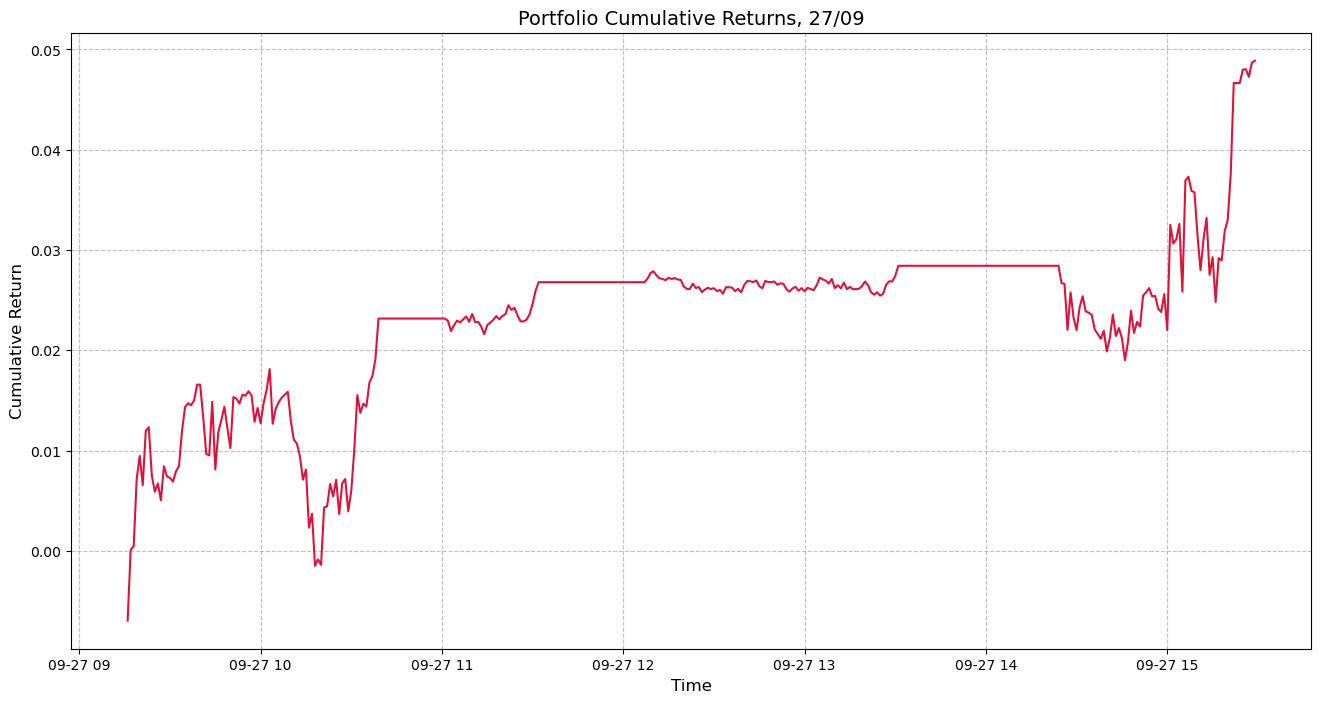

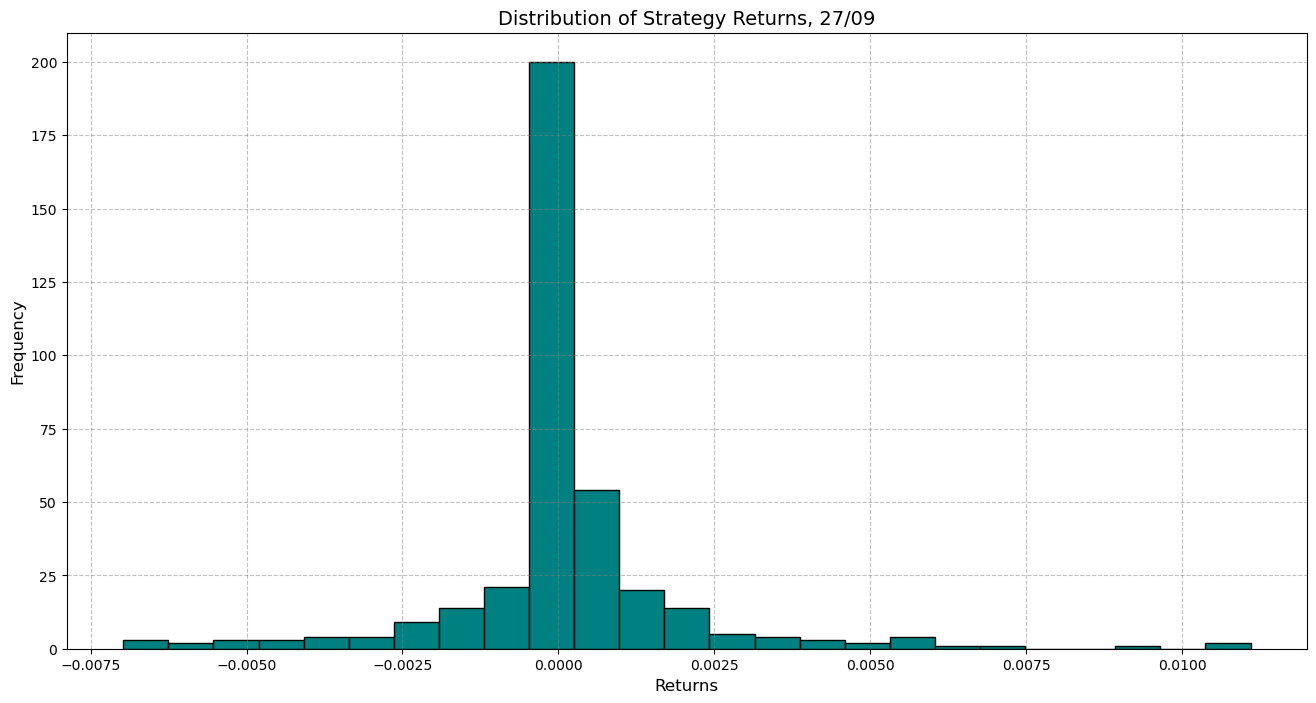

In [15]:
portfolio_df_27 = pd.DataFrame(strategy(stationary27, bajaj27, indianb27, 1000, beta1, beta2, 1)[3], columns=['Date', 'Portfolio Value'])
portfolio_df_27.set_index('Date', inplace=True)


portfolio_df_27["Minutely Return"] = portfolio_df_27["Portfolio Value"].pct_change()

# Plotting the portfolio returns over time
plt.plot(portfolio_df_27["Minutely Return"].cumsum(), c="crimson")
plt.title("Portfolio Cumulative Returns, 27/09")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

# Plotting the distribution of returns over time
plt.hist(portfolio_df_27["Minutely Return"], bins=25, color="teal", edgecolor="black")
plt.title("Distribution of Strategy Returns, 27/09")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

So even using the same hedge ratios from the previous day, the strategy still makes money on unseen data. However, our Sharpe ratio is worse:

In [16]:
# Compute Sharpe Ratio
r = 0  # Take risk free rate to be 0
expected_return = portfolio_df_27['Minutely Return'].mean()
std_return = portfolio_df_27['Minutely Return'].std()
sharpe_ratio = ( (expected_return - r)/std_return )
annualized_sharpe = sharpe_ratio * np.sqrt(252)
# Annualize using √252, number of trading days

annualized_sharpe 

1.085621917161119

There are a few directions we could go in from here; two obvious ones are the computation of the hedge ratios and the position sizing.

In the above we work with fixed hedge ratios; a better way to proceed would be to dynamically update the hedge ratios as the day progresses; that way we know we will always be working with a stationary spread (assuming that the cointegration between the assets persists) and we will always be shorting the right amount.

The above strategy also has a fixed position size; we only ever long 1 unit of the asset we're longing and short beta units of the asset we're shorting. This means that the initial allocation has no influence on the pnl of the strategy. What would be more appropriate is to adjust the position size depending on some factor, for instance the recent volatility.